# CNN vs MLP on MNIST

### Initialisising Colab drive

In [1]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 20.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [2]:
# http://pytorch.org/
!pip install torch

import torch
print(f"Your Pytorch version is {torch.__version__}.")

Your Pytorch version is 1.0.1.post2.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/6135/Assignment_1.2"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
6135-Assignment_1.2.ipynb  best_CNN_1  best_CNN_2  best_CNN_3  best_MLP_2L


### Librairies

In [4]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


print("Libraries ready")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = device.type == 'cuda'
print(device, cuda)

Libraries ready
cuda:0 True


### Dataset

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))

test_data = datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))


Processing...
Done!


In [0]:
batch_size = 128

valid_size = 15000

indices = list(range(len(train_data)))
random.shuffle(indices)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[valid_size:]),
    num_workers=4,
    pin_memory=cuda
)

valid_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[:valid_size]),
    num_workers=4,
    pin_memory=cuda,
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=cuda,
)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [0]:
def showRandSample(dataset, n_row=5, n_col=5):
    nb_img = n_row * n_col
    
    sample_loader = DataLoader(
      dataset,
      batch_size=nb_img, 
      shuffle=True,
      num_workers=1,
      pin_memory=cuda)

    images, labels = next(iter(sample_loader))
    images = images.squeeze()
    
    fig = plt.figure(figsize=(n_row*2, n_col*2))

    for i in range(1, nb_img +1):
        img = images[i-1]    
        ax = fig.add_subplot(n_row, n_col, i)
        ax.set_title(str(labels[i-1].item()))
        plt.axis('off')
        plt.imshow(img,cmap='gray_r')
    plt.show()

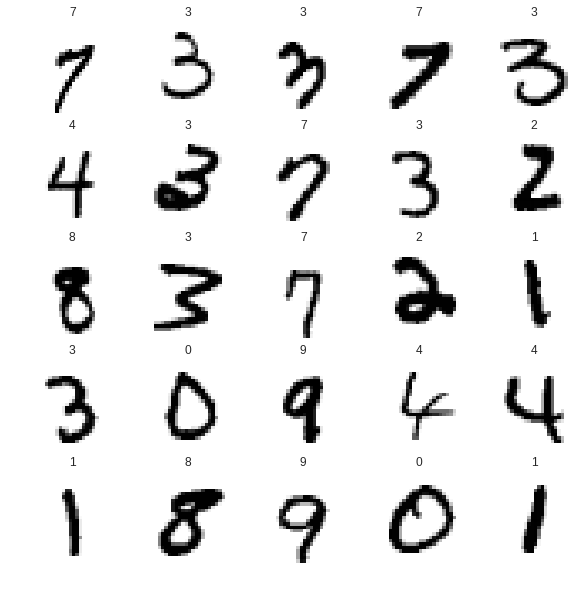

In [9]:
showRandSample(train_data) 

### MLP 
First as our compairason model we chose a strong MLP comming out of part 1, which is a simple model with 2 hidden layers of 512 and 768 neurons with Relu as the activation function. 

In [0]:
class MLP_2L(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        h1 = 512
        h2 = 768
        
        # Fully connected layer
        self.fc0 = nn.Linear(28*28, h1)
        self.fc1 = nn.Linear(h1, h2)
        self.fc2 = nn.Linear(h2, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


### CNN

To expose the effects of convolution on an image classification task, we build a simple CNN with convolution layers replacing a part of the MLP, in this case the first hidden layer.

Simply put : we replace the first hidden layer of the MLP with a convolution block.  
So, where we had :

[input]->[hidden 1]->[hidden 2]->[ouput]

we now have :

[input]->[convolution]->[hidden 2]->[ouput]


We tested 3 models CNN1, CNN2, CNN3 with a convolution block of 1 round, 2 rounds and 3 rounds of convolution.

Since our MLP's hidden layers have 512 and 768 neurons respectively and a total of 803k paramaters, we had few choices in designing those layers.   For CNN1 it is simply not possible to respect both conditions, we chose to respect the hidden layer; so the total number of parameters is half of the MLP.  CNN2 & CNN3 have not only the ~same amount of parameters but also the same hidden layer.

We effectively only **replace** the first hidden layer.  It also leads to a nicely balanced number of parameters compared to the MLP. (ie: the convotion part $\approx$ h1 of the MLP).   This way, the design patterns stay consistant troughout all of the models.


Here are the designs of the convolution block for the 3 models which all result in a layer of 512 neurons :

##### CNN1

{[  $32$ , $3\times3$ ]->[pooling $7$]}


##### CNN2

{[  $87$ , $3\times3$ ]->[pooling $3$]} -> {[  $512$ , $3\times3$ ]->[pooling $10$]}


##### CNN3

{[  $64$ , $3\times3$ ]->[pooling $2$]} -> {[  $77$ , $3\times3$ ]->[pooling $4$]} -> {[  $512$ , $3\times3$ ]->[pooling $4$]}



$87$ and $77$ might seem like strange numbers, they are chosen simply so that total number of parameters is as close to 803k as possible.
The last round of convolution for CNN2&3 must be of 512 filters with pooling down to 1 so that it connects to the hidden layer just like the MLP.  The filters are all $3\times3$ with stride of of $1$ so as to remain consistant, the adaptation factor for the size commes only from the padding in the first layer.  (by coincidence it is $1$, $2$, $3$ for CNN 1, 2 ,3 )  


In [0]:
class CNN_1(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Conv block
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(32*4*4, 768)
        self.fc2 = nn.Linear(768, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 7)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
      
class CNN_2(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Conv block
        self.conv1 = nn.Conv2d(1, 87, 3, padding=2)
        self.conv2 = nn.Conv2d(87, 512, 3, padding=1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(512*1*1, 768)
        self.fc2 = nn.Linear(768, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 3)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 10)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x     
      
class CNN_3(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Conv block
        self.conv1 = nn.Conv2d(1, 64, 3, padding=3)
        self.conv2 = nn.Conv2d(64, 77, 3, padding=1)
        self.conv3 = nn.Conv2d(77, 512, 3, padding=1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(512*1*1, 768)
        self.fc2 = nn.Linear(768, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 4)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 4)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x   


### Model verification and number of parameters :

In [26]:
#Number of parameters
from torchsummary import summary

model = CNN_1().to(device)

print("CNN_1 : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))


model = CNN_2().to(device)

print("\nCNN_2 : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))

model = CNN_3().to(device)

print("\nCNN_3 : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))

model = MLP_2L().to(device)

print("\nMLP_2L : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))

CNN_1 :  401994
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Linear-2                  [-1, 768]         393,984
            Linear-3                   [-1, 10]           7,690
Total params: 401,994
Trainable params: 401,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 1.53
Estimated Total Size (MB): 1.73
----------------------------------------------------------------

CNN_2 :  803952
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 87, 30, 30]             870
            Conv2d-2          [-1, 512, 10, 10]         401,408
            Linear-3                  [-1, 768]         393,984
        

In [0]:
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

#Results directory
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)


## Saved states are ignored for this expirement

#checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks//6135/Assignment_1.2')
#model.load_state_dict(checkpoint['state_dict'])

In [0]:
def train(model,train_loader, optimizer, epoch, scheduler):
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs = inputs.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:  
            print(model.__class__.__name__,' Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch +1, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))
    
    scheduler.step()

In [0]:
def test(model, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in valid_loader:
            inputs = inputs.to(device,dtype=torch.float) 
            target = target.to(device, dtype=torch.long)
            
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() 
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

### Running the experiment

The experiment being non-determinist, depending on weight initialisation and the draw of the training set, 
we run the experiment multiple times and take the average results for each correspoding epochs, reseting all weights and sets for each run.

Here : 10 runs of 10 epochs.

In [0]:
runs = 10
epochs = 10

In [0]:
import pickle

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


def MultipleRun(runs,epochs,model):
  
  model = model.to(device)
  name =  model.__class__.__name__

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)


  results = {'name':name, 'loss': [0]*epochs, 'accuracy':[0]*epochs}
  savefile = os.path.join(savedir, results['name']+'.pkl' )

  best_net = '/content/drive/My Drive/Colab Notebooks//6135/Assignment_1.2/best_' + name
  
  for run in range(runs):
      print("\n","  --  Run : ", run+1)
      since = time.time()
      best_accuracy = 0
      
      #Reseting all weights for new run
      model.apply(weight_reset)

      for epoch in range(epochs):

          train(model, train_loader, optimizer, epoch,exp_lr_scheduler)
          loss, acc = test(model, valid_loader)

          if acc > best_accuracy:
            best_accuracy = acc
                        
            #Saving best model parameters
            torch.save({
                'epoch_based0': epoch,
                'state_dict': model.state_dict(),
                'accuracy': acc,
                'loss' : loss,
                'optimizer' : optimizer.state_dict(),
            }, best_net)

            print('new accuracy parameters saved {}'.format(best_accuracy))

          #Updating average results
          results['loss'][epoch] += loss/runs
          results['accuracy'][epoch] += acc/runs


      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
              time_elapsed // 60, time_elapsed % 60))
    
  with open(savefile, 'wb') as fout:
    pickle.dump(results, fout)

 

### Running CNN1

In [52]:
MultipleRun(runs,epochs,CNN_1())


   --  Run :  1
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.309916
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.894862
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.524122
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.325387

Test set: Average loss: 0.2905, Accuracy: 13695/15000 (91.30%)

new accuracy parameters saved 0.913
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.296037
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.356762
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.217589
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.136585

Test set: Average loss: 0.1777, Accuracy: 14192/15000 (94.61%)

new accuracy parameters saved 0.9461333333333334
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.190420
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.095725
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.164518
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.240140

Test set: Average loss: 0.1457, Accuracy: 14259/15000 (95.06%)

new accuracy parameters saved 0.9506
CNN_1  Epoch: 4 [0/45056 (0%)]	Loss: 0.071724
CNN_1  Epoch: 4 [12800/

### Running CNN2

In [53]:
MultipleRun(runs,epochs,CNN_2())


   --  Run :  1
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.302581
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 1.890951
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.227582
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.432840

Test set: Average loss: 0.5959, Accuracy: 11829/15000 (78.86%)

new accuracy parameters saved 0.7886
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.626503
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.170889
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.102885
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.087838

Test set: Average loss: 0.1559, Accuracy: 14288/15000 (95.25%)

new accuracy parameters saved 0.9525333333333333
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.138652
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.130883
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.164763
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.138317

Test set: Average loss: 0.0907, Accuracy: 14596/15000 (97.31%)

new accuracy parameters saved 0.9730666666666666
CNN_2  Epoch: 4 [0/45056 (0%)]	Loss: 0.019037
CNN_2  Epo

### Running CNN3 

In [54]:
MultipleRun(runs,epochs,CNN_3())


   --  Run :  1
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.300875
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 2.082704
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.705327
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.341417

Test set: Average loss: 0.3642, Accuracy: 13107/15000 (87.38%)

new accuracy parameters saved 0.8738
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.350184
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.143621
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.111957
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.089449

Test set: Average loss: 0.1282, Accuracy: 14386/15000 (95.91%)

new accuracy parameters saved 0.9590666666666666
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.203546
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.043133
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.089760
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.049538

Test set: Average loss: 0.1139, Accuracy: 14452/15000 (96.35%)

new accuracy parameters saved 0.9634666666666667
CNN_3  Epoch: 4 [0/45056 (0%)]	Loss: 0.075681
CNN_3  Epo

#### MLP

In [55]:
MultipleRun(runs,epochs,MLP_2L())



   --  Run :  1
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.306213
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.713640
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.375195
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.347246

Test set: Average loss: 0.3465, Accuracy: 13518/15000 (90.12%)

new accuracy parameters saved 0.9012
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.399282
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.312602
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.358865
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.225480

Test set: Average loss: 0.2626, Accuracy: 13878/15000 (92.52%)

new accuracy parameters saved 0.9252
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.251717
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.203761
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.279361
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Loss: 0.183252

Test set: Average loss: 0.2152, Accuracy: 14080/15000 (93.87%)

new accuracy parameters saved 0.9386666666666666
MLP_2L  Epoch: 4 [0/45056 (0%)]	Loss: 0.170148
MLP_2L  E

### Compairing Results

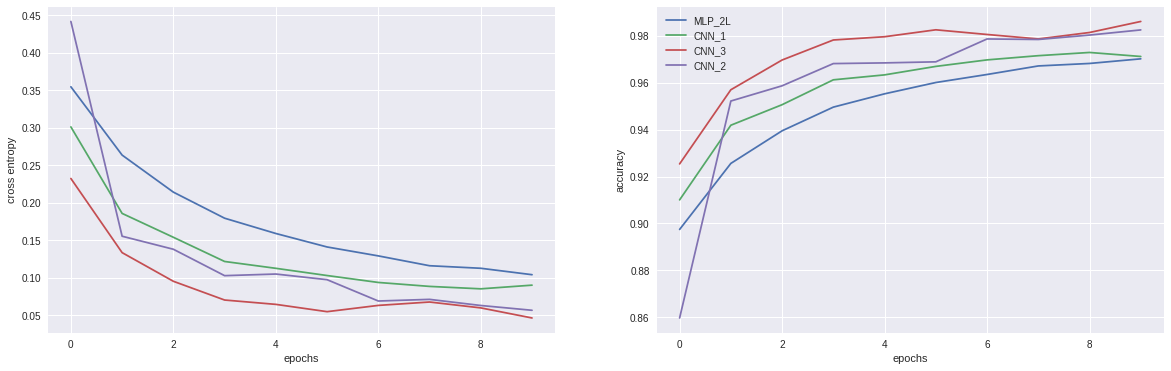

In [58]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

for filename in os.listdir(savedir):
    if filename.endswith('.pkl'):
        with open(os.path.join(savedir, filename),'rb') as fin:
            results = pickle.load(fin)
            ax1.plot(results['loss'], label = filename[:-4])
            ax1.set_ylabel('cross entropy')
            ax1.set_xlabel('epochs')
            
            ax2.plot(results['accuracy'], label = filename[:-4])
            ax2.set_ylabel('accuracy')
            ax2.set_xlabel('epochs')
            
plt.legend()

### Final comments

When looking at the aboves charts, we have to remember that it is plotted from the average of 10 runs of 10 epochs.
So what we see is really the evolution of the models during training.  For exemple: CNN2 always starts with poor results for the first epoch.

##### CNN1
As this model slightly outperforms the MLP at every epoch, we can imagine it also doing better in the long run.  However, since they end up with the same value on the last epoch, we would need a longer run to confirm that.  With half as many parameters as the MLP, it would be tempting to declare this model simply superior to the MLP, but we should not jump to hasty conclusions as we should remember from part 1 that some models with lower number of parameters also performed well, so there might be a redundent amount of neurons that don't contribute much.

Still it is really interesting that we can simply replace 400k parameters with 320 parameters and gain in performance.  It clearly shows that a single layers gets more out of the 32 feature maps then a fully connected layer.

##### CNN2 
With a second round of convolution the effect is even more pronounced and the model now clearly outperforms the MLP.  However this time we have have a convolution of 512 filters for the missing 400k parameters that make it equivalent to the MLP in number of paramters but much better in performance.

##### CNN3
Finnaly this model we conserve the same number of paramaters with another round of convolution thanks to more pooling. Compared to CNN2 , mostly only the architecture changed, being deeper and slightly thinner 

Not only does CNN3, CNN2 and the MLP have similar number of parameters, but they are also distributed and balanced in a similar way, where the parameters in the first fully connected hidden layer are replaced by the parameters of the convolution.

It is unknown with this experiment how much convolution depth we can add and still gain perfomance, either plateau or loose performance.    

What this experiment has shown though with all three models is how much convolution is better then a fully connected layer for image based classification.  MNIST being a relatively simple dataset, we suspect that with a more complex task the difference would be even more pronounced and we could really see the difference in capacity. 
